In [32]:
# script written by Nikolay Markov, from:
# https://github.com/NUPulmonary/scarches-covid-reference/blob/master/sankey.py
# (clumsily) adapted by Lisa Sikkema to enable coloring by right side rather than left side
import collections
import colorsys

import matplotlib.pyplot
import matplotlib.path
import matplotlib.patches


def get_distinct_colors(n):
    """
    https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python/answer/Karthik-Kumar-Viswanathan
    """
    hue_partition = 1 / (n + 1)
    colors = [
        colorsys.hsv_to_rgb(hue_partition * value, 1.0, 1.0) for value in range(0, n)
    ]
    return colors[::2] + colors[1::2]


def text_width(fig, ax, text, fontsize):
    text = ax.text(-100, 0, text, fontsize=fontsize)
    text_bb = text.get_window_extent(renderer=fig.canvas.get_renderer())
    text_bb = text_bb.transformed(fig.dpi_scale_trans.inverted())
    width = text_bb.width
    text.remove()
    return width


class Sankey:
    def __init__(
        self,
        x,
        y,
        colorside,
        plot_width=8,
        plot_height=8,
        gap=0.12,
        alpha=0.3,
        fontsize="small",
        left_order=None,
        mapping=None,
        colors=None,
        #                  colorside=None,
        tag=None,
        title=None,
        title_left=None,
        title_right=None,
        ax=None,
    ):
        self.X = x
        self.Y = y
        if ax:
            self.plot_width = ax.get_position().width * ax.figure.get_size_inches()[0]
            self.plot_height = ax.get_position().height * ax.figure.get_size_inches()[1]
        else:
            self.plot_width = plot_width
            self.plot_height = plot_height
        self.gap = gap
        self.alpha = alpha
        self.colors = colors
        self.colorside = colorside
        self.fontsize = fontsize
        self.tag = tag
        self.map = mapping is not None
        self.mapping = mapping
        self.mapping_colors = {
            "increase": "#1f721c",
            "decrease": "#ddc90f",
            "mistake": "#dd1616",
            "correct": "#dddddd",
            "novel": "#59a8d6",
        }
        self.title = title
        self.title_left = title_left
        self.title_right = title_right

        self.need_title = any(
            map(lambda x: x is not None, (title, title_left, title_right))
        )
        if self.need_title:
            self.plot_height -= 0.5

        self.init_figure(ax)

        self.flows = collections.Counter(zip(x, y))
        self.init_nodes(left_order)

        self.init_widths()
        # inches per 1 item in x and y
        self.resolution = (plot_height - gap * (len(self.left_nodes) - 1)) / len(x)
        if self.colors == None:
            if colorside == "left":
                self.colors = {
                    name: colour
                    for name, colour in zip(
                        self.left_nodes.keys(),
                        get_distinct_colors(len(self.left_nodes)),
                    )
                }
            elif colorside == "right":
                self.colors = {
                    name: colour
                    for name, colour in zip(
                        self.right_nodes.keys(),
                        get_distinct_colors(len(self.right_nodes)),
                    )
                }
            else:
                raise ValueError(
                    "colorside argument should be set either to 'left' or 'right'. Exiting."
                )

        self.init_offsets()

    def init_figure(self, ax):
        if ax is None:
            fig = matplotlib.pyplot.figure()
            ax = matplotlib.pyplot.Axes(fig, [0, 0, 1, 1])
            fig.add_axes(ax)
            
        self.fig = ax.figure
        self.ax = ax

    def init_nodes(self, left_order):
        left_nodes = {}
        right_nodes = {}
        left_offset = 0
        for (left, right), flow in self.flows.items():
            if left in left_nodes:
                left_nodes[left] += flow
            else:
                left_nodes[left] = flow
            if right in right_nodes:
                node = right_nodes[right]
                node[0] += flow
                if flow > node[2]:
                    node[1] = left
                    node[2] = flow
            else:
                right_nodes[right] = [flow, left, flow]

        self.left_nodes = collections.OrderedDict()
        self.left_nodes_idx = {}
        if left_order is None:
            key = lambda pair: -pair[1]
        else:
            left_order = list(left_order)
            key = lambda pair: left_order.index(pair[0])

        for name, flow in sorted(left_nodes.items(), key=key):
            self.left_nodes[name] = flow
            self.left_nodes_idx[name] = len(self.left_nodes_idx)

        left_names = list(self.left_nodes.keys())
        self.right_nodes = collections.OrderedDict()
        self.right_nodes_idx = {}
        for name, node in sorted(
            right_nodes.items(),
            key=lambda pair: (left_names.index(pair[1][1]), -pair[1][2]),
        ):
            self.right_nodes[name] = node[0]
            self.right_nodes_idx[name] = len(self.right_nodes_idx)

    def init_widths(self):
        self.left_width = max(
            (
                text_width(self.fig, self.ax, node, self.fontsize)
                for node in self.left_nodes
            )
        )
        if self.title_left:
            self.left_width = max(
                self.left_width,
                text_width(self.fig, self.ax, self.title_left, self.fontsize) / 2,
            )
        self.right_width = max(
            (
                text_width(self.fig, self.ax, node, self.fontsize)
                for node in self.right_nodes
            )
        )
        if self.title_right:
            self.right_width = max(
                self.right_width,
                text_width(self.fig, self.ax, self.title_right, self.fontsize) / 2,
            )

        self.right_stop = self.plot_width - self.left_width - self.right_width
        self.middle1_stop = self.right_stop * 9 / 20
        self.middle2_stop = self.right_stop * 11 / 20

    def init_offsets(self):
        self.offsets_l = {}
        self.offsets_r = {}

        offset = 0
        for name, flow in self.left_nodes.items():
            self.offsets_l[name] = offset
            offset += flow * self.resolution + self.gap

        offset = 0
        for name, flow in self.right_nodes.items():
            self.offsets_r[name] = offset
            offset += flow * self.resolution + self.gap

    def draw_flow(self, left, right, flow, node_offsets_l, node_offsets_r, colorside):
        P = matplotlib.path.Path

        flow *= self.resolution
        left_y = self.offsets_l[left] + node_offsets_l[left]
        right_y = self.offsets_r[right] + node_offsets_r[right]
        if self.need_title:
            left_y += 0.5
            right_y += 0.5
        node_offsets_l[left] += flow
        node_offsets_r[right] += flow
        if colorside == "left":
            color = self.colors[left]
        elif colorside == "right":
            color = self.colors[right]
        if self.mapping is not None:
            color = self.mapping_colors[self.mapping.category(left, right)]

        path_data = [
            (P.MOVETO, (0, -left_y)),
            (P.LINETO, (0, -left_y - flow)),
            (P.CURVE4, (self.middle1_stop, -left_y - flow)),
            (P.CURVE4, (self.middle2_stop, -right_y - flow)),
            (P.CURVE4, (self.right_stop, -right_y - flow)),
            (P.LINETO, (self.right_stop, -right_y)),
            (P.CURVE4, (self.middle2_stop, -right_y)),
            (P.CURVE4, (self.middle1_stop, -left_y)),
            (P.CURVE4, (0, -left_y)),
            (P.CLOSEPOLY, (0, -left_y)),
        ]
        codes, verts = zip(*path_data)
        path = P(verts, codes)
        patch = matplotlib.patches.PathPatch(
            path,
            facecolor=color,
            alpha=0.9 if flow < 0.02 else self.alpha,
            edgecolor="none",
        )
        self.ax.add_patch(patch)

    def draw_label(self, label, is_left):
        nodes = self.left_nodes if is_left else self.right_nodes
        offsets = self.offsets_l if is_left else self.offsets_r
        y = offsets[label] + nodes[label] * self.resolution / 2
        if self.need_title:
            y += 0.5

        self.ax.text(
            -0.1 if is_left else self.right_stop + 0.1,
            -y,
            label,
            horizontalalignment="right" if is_left else "left",
            verticalalignment="center",
            fontsize=self.fontsize,
        )

    def draw_titles(self):
        if self.title:
            self.ax.text(
                self.right_stop / 2,
                -0.25,
                self.title,
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=self.fontsize,
                fontweight="bold",
            )
        if self.title_left:
            self.ax.text(
                -0.1,
                -0.25,
                self.title_left,
                horizontalalignment="right",
                verticalalignment="center",
                fontsize=self.fontsize,
            )
        if self.title_right:
            self.ax.text(
                self.right_stop + 0.1,
                -0.25,
                self.title_right,
                horizontalalignment="left",
                verticalalignment="center",
                fontsize=self.fontsize,
            )

    def draw(self, colorside):
        node_offsets_l = collections.Counter()
        node_offsets_r = collections.Counter()

        for (left, right), flow in sorted(
            self.flows.items(),
            key=lambda pair: (
                self.left_nodes_idx[pair[0][0]],
                self.right_nodes_idx[pair[0][1]],
            ),
        ):
            self.draw_flow(left, right, flow, node_offsets_l, node_offsets_r, colorside)

        for name in self.left_nodes:
            self.draw_label(name, True)
        for name in self.right_nodes:
            self.draw_label(name, False)
        self.draw_titles()

        self.ax.axis("equal")
        self.ax.set_xlim(
            -self.left_width - self.gap, self.right_stop + self.gap + self.right_width
        )
        self.ax.get_xaxis().set_visible(False)
        self.ax.get_yaxis().set_visible(False)
        for k in self.ax.spines.keys():
            self.ax.spines[k].set_visible(False)
        # matplotlib.pyplot.axis('off')
        # self.fig.set_figheight(self.plot_height)
        # self.fig.set_figwidth(self.plot_width)
        if self.tag:
            text_ax = self.fig.add_axes((0.02, 0.95, 0.05, 0.05), frame_on=False)
            text_ax.set_axis_off()
            matplotlib.pyplot.text(
                0, 0, self.tag, fontsize=30, transform=text_ax.transAxes
            )
        # matplotlib.pyplot.tight_layout()


def sankey(x, y, colorside="left", **kwargs):
    diag = Sankey(x, y, colorside, **kwargs)
    diag.draw(colorside)
    return diag.fig

In [33]:
import pandas as pd


In [56]:
df = pd.read_csv("../output/scRNA/output/annotation_df.csv")

/tmp/ipykernel_420036/2101090853.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/scRNA/output/annotation_df.csv")


In [41]:
celltype  = df["celltype"].values

In [46]:
colors

NameError: name 'na' is not defined

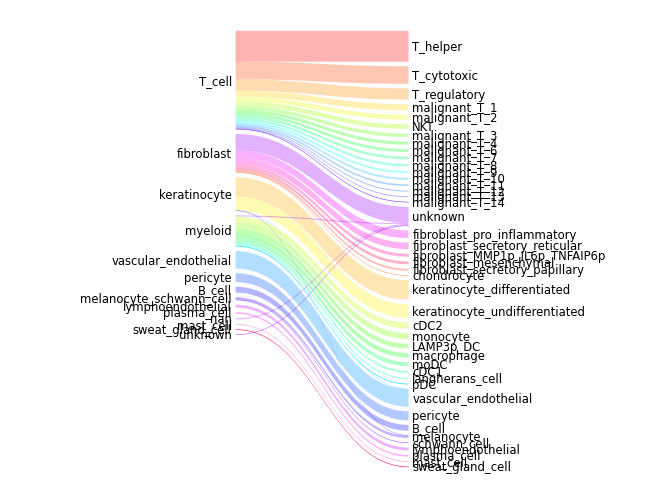

In [57]:
import matplotlib.pyplot as plt

f = sankey(x = df["celltype.broad"].values, y = df['celltype'].values, colorside="right")
f.savefig("../output/scRNA/output/sankey_plot.pdf", bbox_inches='tight')

In [24]:
def init_figure(self, ax):
        if ax is None:
            self.fig = matplotlib.pyplot.figure()
            self.ax = matplotlib.pyplot.Axes(self.fig, [0, 0, 1, 1])
            self.fig.add_axes(self.ax)
        self.fig = ax.figure
        self.ax = ax

In [17]:
fig = matplotlib.pyplot.figure()
ax = matplotlib.pyplot.Axes(fig, [0, 0, 1, 1])

<Figure size 640x480 with 0 Axes>

In [19]:
fig.add_axes(ax)

<Axes: >

In [22]:
fig = ax.figure

In [23]:
colorsys.

In [53]:
get_distinct_colors(20)

[(1.0, 0.0, 0.0),
 (1.0, 0.5714285714285714, 0.0),
 (0.8571428571428572, 1.0, 0.0),
 (0.2857142857142858, 1.0, 0.0),
 (0.0, 1.0, 0.2857142857142856),
 (0.0, 1.0, 0.8571428571428568),
 (0.0, 0.5714285714285716, 1.0),
 (0.0, 0.0, 1.0),
 (0.5714285714285712, 0.0, 1.0),
 (1.0, 0.0, 0.8571428571428577),
 (1.0, 0.2857142857142857, 0.0),
 (1.0, 0.8571428571428571, 0.0),
 (0.5714285714285716, 1.0, 0.0),
 (0.0, 1.0, 0.0),
 (0.0, 1.0, 0.5714285714285712),
 (0.0, 0.8571428571428577, 1.0),
 (0.0, 0.2857142857142856, 1.0),
 (0.2857142857142847, 0.0, 1.0),
 (0.8571428571428577, 0.0, 1.0),
 (1.0, 0.0, 0.5714285714285721)]